<a href="https://colab.research.google.com/github/anpaure/lm_compression/blob/main/compress_token.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login
from google.colab import userdata
import torch

# Enable cuda optimizations
torch.backends.cudnn.benchmark = True  # Enable cudnn auto-tuner
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on matmul
torch.backends.cudnn.allow_tf32 = True  # Allow TF32 on cudnn

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If using GPU, print some info
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) // 1024**2}MB")

HF_TOKEN = userdata.get("HF_TOKEN")
login(token=HF_TOKEN)
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model with mixed precision
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use float16 for faster computation
    device_map='auto'  # Automatically handle model placement
)

# Optional: enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

torch.manual_seed(42)


In [2]:
import random
def encode(text, tokenizer, model):
    tokens = tokenizer.encode(text, return_tensors="pt")[0].to(device) # Move tokens to the device
    positions = []

    for i in range(1, len(tokens)):
        input_ids = tokens[:i].unsqueeze(0).to(device) # Move input_ids to the device

        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)[0]

        # Sort probabilities and get indices
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)  # Sort in descending order

        # Find position of the ground truth token
        ground_truth_token = tokens[i].item()
        ground_truth_pos = (sorted_indices == ground_truth_token).nonzero().item()

        # Debug printing
        if random.random() < 0.001:  # Print every 3% of iterations
            print(f"\nTop 5 predicted tokens:")
            for j in range(5):
                token = sorted_indices[j].item()
                prob = sorted_probs[j].item()
                print(f"Token {token} ({tokenizer.decode([token])}): {prob:.4f}")

        print(f"\nGround truth token: {ground_truth_token} ({tokenizer.decode([ground_truth_token])})")
        print(f"Position in sorted list: {ground_truth_pos}")

        positions.append(ground_truth_pos)

    return tokens[0].item(), positions

def decode(first_token, positions, tokenizer, model):
    # Initialize with the first token
    recovered_tokens = [first_token]

    # Reconstruct the sequence
    for pos in positions:
        # Get current sequence
        input_ids = torch.tensor(recovered_tokens, device=device).unsqueeze(0) # Create tensor on the device

        # Get model's predictions
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)[0]

        # Sort probabilities and get indices (descending order to match encode)
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)

        # Get the token at the specified position
        next_token = sorted_indices[pos].item()
        recovered_tokens.append(next_token)

        # Debug printing (optional)
        if random.random() < 0.001:  # Print every 0.1% of iterations
            print(f"\nRecovered so far: {tokenizer.decode(recovered_tokens)}")
            print(f"Added token {next_token} ({tokenizer.decode([next_token])})")

    # Decode the complete sequence
    recovered_text = tokenizer.decode(recovered_tokens)
    return recovered_text

In [ ]:
text = "mps device enables high-performance training on GPU for MacOS devices with Metal programming framework. It introduces a new device to map Machine Learning computational graphs."
tokens = encode(text, tokenizer, model)
print(tokens)
decoded = decode(tokens[0], tokens[1], tokenizer, model)
print(decoded)

In [4]:
def save_encoded(first_token, positions, filename="encoded.txt"):
    with open(filename, "w") as f:
        f.write(f"{first_token}\n")  # First line is the initial token
        # Convert positions to comma-separated string
        positions_str = ",".join(map(str, positions))
        f.write(positions_str)

def load_encoded(filename="encoded.txt"):
    with open(filename, "r") as f:
        first_token = int(f.readline().strip())
        positions = [int(x) for x in f.readline().strip().split(",")]
    return first_token, positions

# Complete pipeline
def compress_file(input_file="text.txt", encoded_file="encoded.txt", decoded_file="decoded.txt"):
    # Read input
    with open(input_file, "r") as f:
        text = f.read()

    # Encode
    first_token, positions = encode(text, tokenizer, model)

    # Save encoded
    save_encoded(first_token, positions, encoded_file)

    # Decode and save
    decoded_text = decode(first_token, positions, tokenizer, model)
    with open(decoded_file, "w") as f:
        f.write(decoded_text)
#compress_file()

In [5]:
import gzip
import os

def compress_encoded(first_token, positions, output_file="encoded.txt.gz"):
    # Convert data to string format
    data = f"{first_token}\n" + ",".join(map(str, positions))

    # Compress with gzip
    with gzip.open(output_file, 'wt') as f:
        f.write(data)

def decompress_encoded(input_file="encoded.txt.gz"):
    # Read and decompress
    with gzip.open(input_file, 'rt') as f:
        lines = f.read().split('\n')
        first_token = int(lines[0])
        positions = [int(x) for x in lines[1].split(',')]
    return first_token, positions

# Complete pipeline with compression
def compress_file_with_wrapper(input_file="text.txt", encoded_file="encoded.txt.gz", decoded_file="decoded.txt"):
    # Read input
    with open(input_file, "r") as f:
        text = f.read()

    # Encode using LLM
    first_token, positions = encode(text, tokenizer, model)

    # Compress and save encoded data
    compress_encoded(first_token, positions, encoded_file)

    # Get file sizes for comparison
    original_size = len(text.encode('utf-8'))
    compressed_size = os.path.getsize(encoded_file)
    print(f"Original size: {original_size} bytes")
    print(f"Compressed size: {compressed_size} bytes")
    print(f"Compression ratio: {compressed_size/original_size:.2f}")

    # Decompress and decode
    first_token, positions = decompress_encoded(encoded_file)
    decoded_text = decode(first_token, positions, tokenizer, model)

    # Save decoded text
    with open(decoded_file, "w") as f:
        f.write(decoded_text)

    return original_size, compressed_size

# Test it with a local file text.txt
#compress_file_with_wrapper()


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
def get_enwik_sample(size_bytes=10000):
    """
    Get sample from enwik8 dataset using Hugging Face datasets
    """
    try:
        # Load the raw version of the dataset
        dataset = load_dataset("LTCB/enwik8", 'enwik8-raw')

        # Get the raw text
        full_text = dataset['train'][0]['text']

        # Take the first size_bytes bytes
        sample = full_text[:size_bytes]

        return sample

    except Exception as e:
        print(f"Error loading enwik8 dataset: {e}")
        return """The Project Gutenberg eBook of The Foundations of Science: Science and Hypothesis,
                The Value of Science, Science and Method, by Henri Poincaré"""
def test_compression_sizes(sizes=[1000, 4000]):
    """
    Test compression performance on different sizes of enwik data,
    including compression of both original text and LLM output
    """
    results = []

    # Get the full text once
    full_text = get_enwik_sample(max(sizes))

    for size in sizes:
        print(f"\nTesting with {size} bytes of enwik data:")
        text = full_text[:size]
        print(f"Sample text (first 100 chars): {text[:100]}...")

        # Encode using LLM
        first_token, positions = encode(text, tokenizer, model)

        # Get original size
        original_size = len(text.encode('utf-8'))

        # Create LLM encoded data
        encoded_data = f"{first_token}\n" + ",".join(map(str, positions))
        llm_size = len(encoded_data.encode('utf-8'))

        # Compression methods
        import bz2
        import lzma

        # Compress original text
        orig_gzip_size = len(gzip.compress(text.encode('utf-8')))
        orig_bz2_size = len(bz2.compress(text.encode('utf-8')))
        orig_lzma_size = len(lzma.compress(text.encode('utf-8')))

        # Compress LLM output
        llm_gzip_size = len(gzip.compress(encoded_data.encode('utf-8')))
        llm_bz2_size = len(bz2.compress(encoded_data.encode('utf-8')))
        llm_lzma_size = len(lzma.compress(encoded_data.encode('utf-8')))

        result = {
            'input_size': size,
            'original_size': original_size,
            'orig_gzip_size': orig_gzip_size,
            'orig_bz2_size': orig_bz2_size,
            'orig_lzma_size': orig_lzma_size,
            'llm_size': llm_size,
            'llm_gzip_size': llm_gzip_size,
            'llm_bz2_size': llm_bz2_size,
            'llm_lzma_size': llm_lzma_size,
        }

        # Print results
        print(f"\nCompression results for {size} bytes:")
        print(f"Original text length: {len(text)} characters")
        print(f"Original size: {original_size:,} bytes")
        print("\nDirect compression of original text:")
        print(f"Gzip: {orig_gzip_size:,} bytes (ratio: {orig_gzip_size/original_size:.2f})")
        print(f"BZ2: {orig_bz2_size:,} bytes (ratio: {orig_bz2_size/original_size:.2f})")
        print(f"LZMA: {orig_lzma_size:,} bytes (ratio: {orig_lzma_size/original_size:.2f})")

        print("\nLLM encoding + compression:")
        print(f"LLM only: {llm_size:,} bytes (ratio: {llm_size/original_size:.2f})")
        print(f"LLM+Gzip: {llm_gzip_size:,} bytes (ratio: {llm_gzip_size/original_size:.2f})")
        print(f"LLM+BZ2: {llm_bz2_size:,} bytes (ratio: {llm_bz2_size/original_size:.2f})")
        print(f"LLM+LZMA: {llm_lzma_size:,} bytes (ratio: {llm_lzma_size/original_size:.2f})")

        # Verify reconstruction
        decoded_text = decode(first_token, positions, tokenizer, model)
        print(f"\nReconstruction successful: {text == decoded_text}")

        results.append(result)

    return results

# Test with different sizes
results = test_compression_sizes([1000, 4000])

# Plot results with matplotlib
try:
    import matplotlib.pyplot as plt
    import pandas as pd

    df = pd.DataFrame(results)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot original text compression
    for method in ['orig_gzip_size', 'orig_bz2_size', 'orig_lzma_size']:
        ax1.plot(df['input_size'], df[method]/df['original_size'],
                label=method.replace('orig_', '').replace('_size', ''), marker='o')
    ax1.set_title('Direct Compression Ratios')
    ax1.set_xlabel('Input Size (bytes)')
    ax1.set_ylabel('Compression Ratio')
    ax1.grid(True)
    ax1.legend()

    # Plot LLM + compression
    for method in ['llm_size', 'llm_gzip_size', 'llm_bz2_size', 'llm_lzma_size']:
        ax2.plot(df['input_size'], df[method]/df['original_size'],
                label=method.replace('llm_', 'LLM+').replace('_size', ''), marker='o')
    ax2.set_title('LLM-based Compression Ratios')
    ax2.set_xlabel('Input Size (bytes)')
    ax2.set_ylabel('Compression Ratio')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

except ImportError:
    print("Plotting libraries not available")


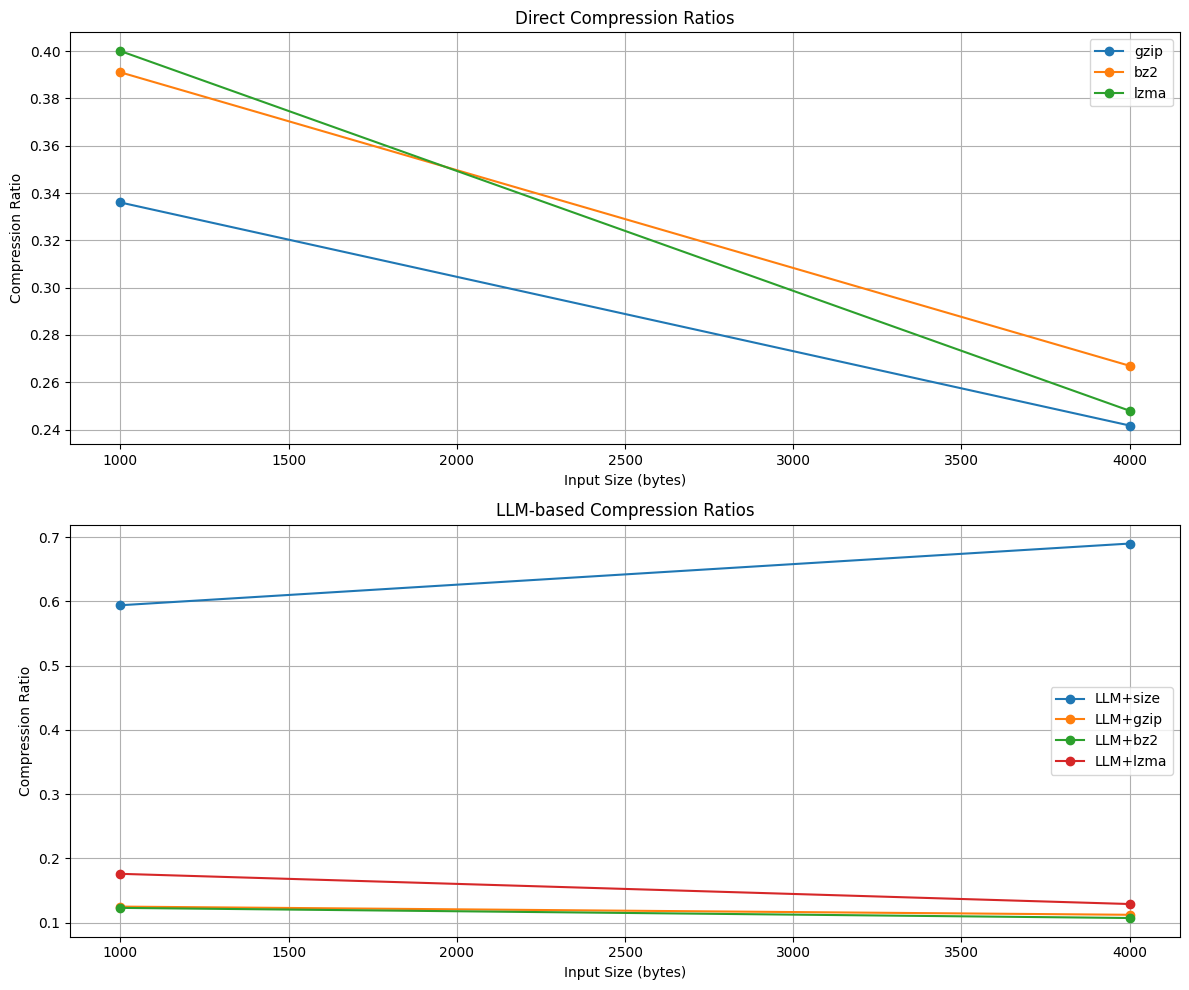